# Kaggle Project

## Classify gestures by reading muscle activity

**URL:** https://www.kaggle.com/datasets/kyr7plus/emg-4/

**Task:**

...

...

**Datasets**

* Train dataset: ...

* Validation dataset: ...

* Test dataset: ...

**Features(x):**

...

...

**Target(y):**

...

...

---

## Build Your Model

### Data preprocessing

In [2]:
## codes

### Model Construction

In [3]:
## codes

### Train Model & Select Model

In [4]:
## codes

---

## Performance

In [5]:
## codes

The results explains

....

In [6]:
import torch
import torchvision
import torchmetrics
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import time
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score

Context
다양한 자유도를 가진 의수 제어 시스템을 만들고 있으며, 이 시스템은 의수 장치의 다양한 동작 수행을 가능하게 합니다

MYO 팔찌를 이용하여 앱을 통해 네 가지 동작의 모션을 기록했습니다
MYO 팔찌에 배치된 8개의 센서를 통해 피부 표면 아래의 근육에서 발생하는 전기적 신호(근전도)를 측정

각 dataset line은 모두 8개의 센서에서 8번 연속적인 측정이 이루어지므로, 64개의 column이 존재합니다.
마지막 column은 0~3의 제스처를 구분하는 클래스가 기록되어 있습니다.

[8센서][8센서][8센서][8센서][8센서][8센서][8센서][8센서][제스처_클래스]

64개의 숫자가 주어지면, 분류기는 제스처 클래스(0-3)를 예측할 것입니다.

바위 - 0
가위 - 1
보 - 2
OK - 3

각 제스처는 20초 동안 6번 기록되었습니다.
각 기록은 제스처가 이미 준비되어 유지되고 있는 상태에서 시작되었습니다.
기록은 제스처가 여전히 유지되고 있는 상태에서 중단되었습니다.
총 120초의 각 제스처가 고정된 위치에서 기록되었으며, 모두 동일한 오른쪽 팔에서 짧은 시간에 걸쳐 기록되었습니다. 

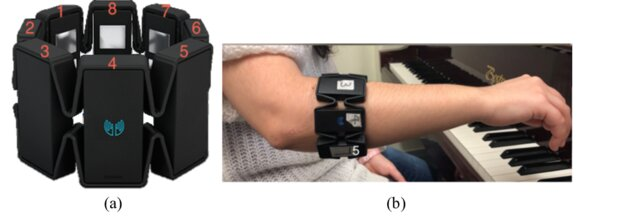

In [7]:
path = Path(r'C:/Users/tjfwo/OneDrive/바탕 화면/GIT_Repository/study/Biosignals/EMG-Torch/archive')

In [8]:
df0 = pd.read_csv(path / '0.csv', header=None)
df1 = pd.read_csv(path / '1.csv', header=None)
df2 = pd.read_csv(path / '2.csv', header=None)
df3 = pd.read_csv(path / '3.csv', header=None)
df = pd.concat([df0, df1, df2, df3])
data = df.values
print("Data Shape", data.shape)

Data Shape (11678, 65)


In [9]:
sc = MinMaxScaler(feature_range = (0,1)) # 데이터를 0-1 사이의 값으로 변환

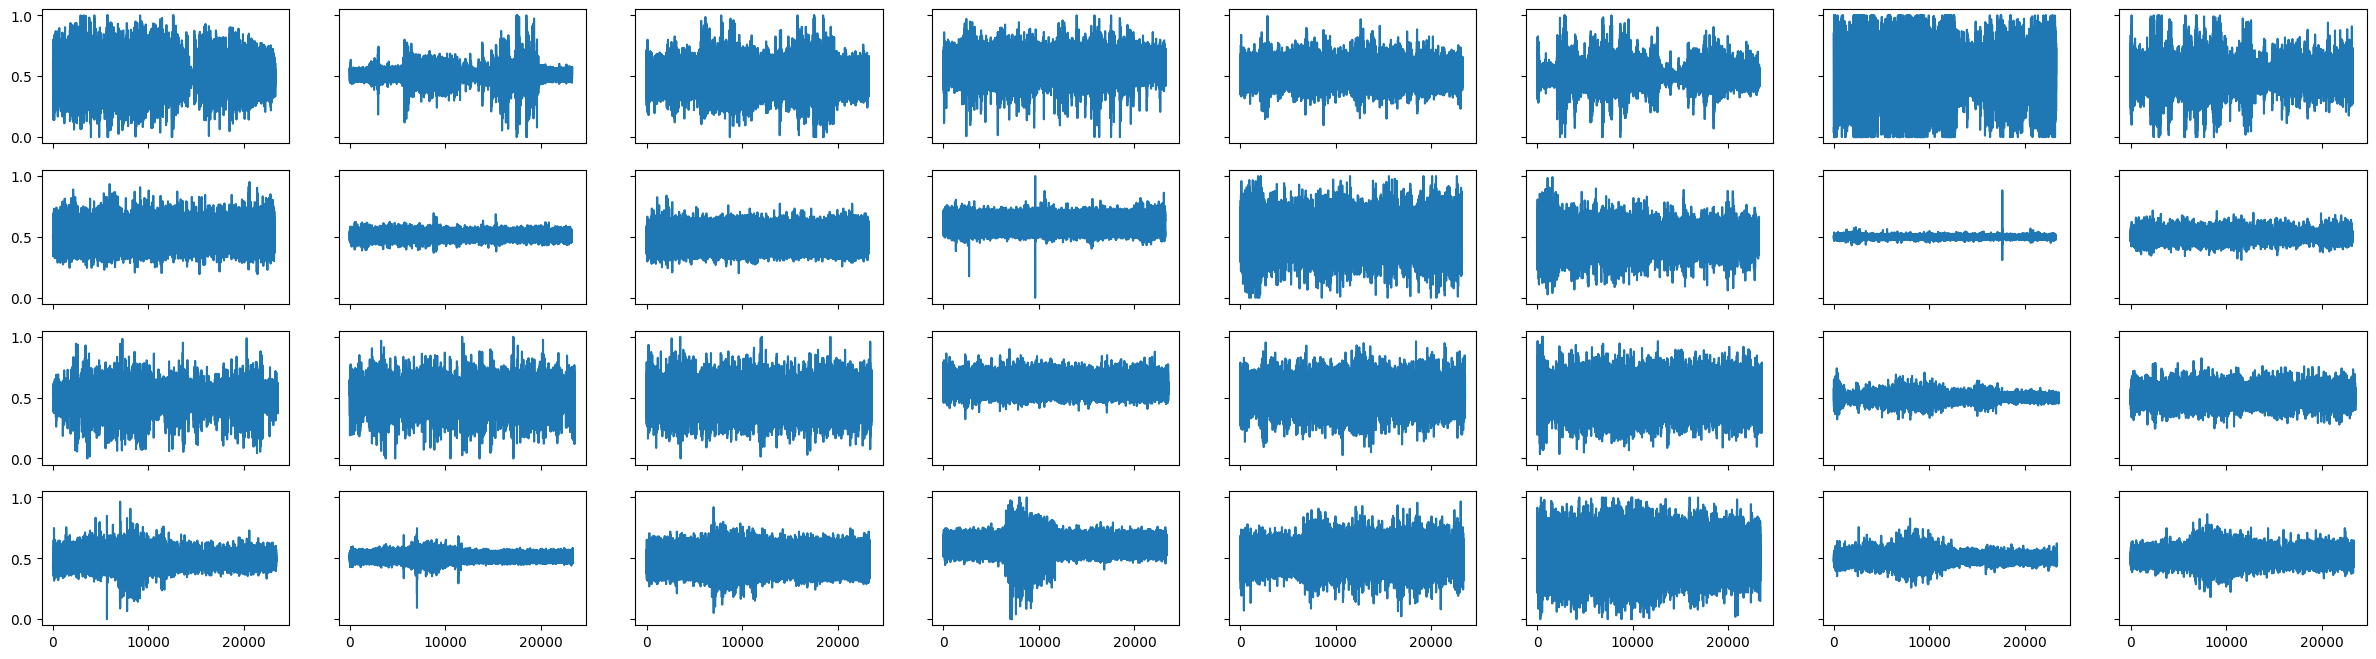

In [10]:
# 데이터 시각화
def plot_data(data):
    
    X0, X1, X2, X3=[],[],[],[]
    data[:,:-1] = sc.fit_transform(data[:,:-1]) # 데이터 normalization
    
    for i in range(data.shape[0]): # 데이터 재구조화
        tmp = data[i,:-1].reshape((8,8))
        for j in range(8):
            if data[i,-1] == 0:
                X0.append(tmp[j,:])
            elif data[i,-1] == 1:
                X1.append(tmp[j,:])
            elif data[i,-1] == 2:
                X2.append(tmp[j,:])
            elif data[i,-1] == 3:
                X3.append(tmp[j,:])
    
    X0, X1, X2, X3 = np.array(X0), np.array(X1), np.array(X2), np.array(X3) # 데이터 분류
        
    fig, axes = plt.subplots(4,8, figsize=(30, 8), sharex=True, sharey=True) # 데이터 시각화
    for i in range(8):
        axes[0][i].plot(X0[:,i], label='Raw Ch '+str(i))
        axes[1][i].plot(X1[:,i], label='Raw Ch '+str(i))
        axes[2][i].plot(X2[:,i], label='Raw Ch '+str(i))
        axes[3][i].plot(X3[:,i], label='Raw Ch '+str(i))
    plt.show()
plot_data(data)

c:\Users\tjfwo\OneDrive\바탕 화면\GIT_Repository\DGU-MLDL\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tjfwo\OneDrive\바탕 화면\GIT_Repository\DGU-MLDL\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\tjfwo\OneDrive\바탕 화면\GIT_Repository\DGU-MLDL\venv\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='64', ylabel='count'>

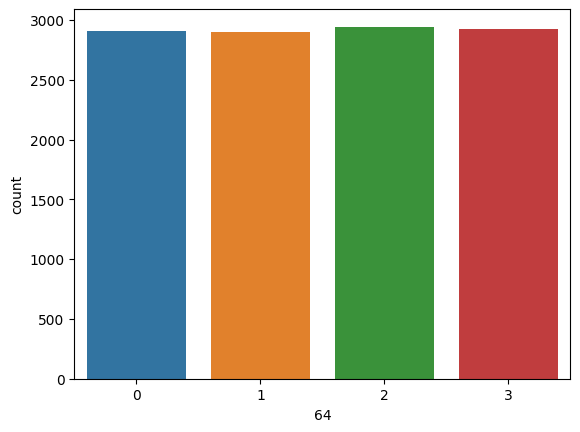

In [11]:
sns.countplot(x=64, data=df)

In [12]:
X = df.drop([64], axis = 1)
Y = df.drop(df.index[0:64], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    test_size = 0.2,
    random_state = 0,
    shuffle = True,
    stratify = Y)

X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size = 0.2,
    random_state = 0,
    shuffle = True,
    stratify = y_train)

X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_train = y_train.flatten()

X_val = torch.tensor(X_val.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.long)
y_val = y_val.flatten()

X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)
y_test = y_test.flatten()

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

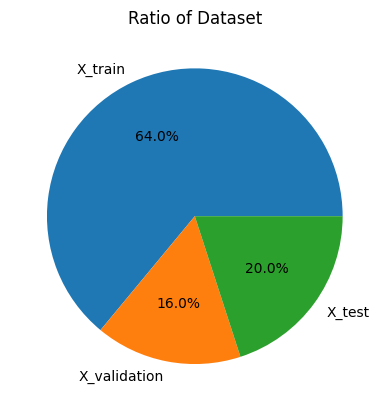

In [13]:
total = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]

train_ratio = (X_train.shape[0] / total) * 100
validation_ratio = (X_val.shape[0] / total) * 100
test_ratio = (X_test.shape[0] / total) * 100

data = [train_ratio, validation_ratio, test_ratio]
labels = ['X_train', 'X_validation', 'X_test']

plt.pie(data, labels = labels, autopct = '%1.1f%%')
plt.title('Ratio of Dataset')
plt.show()

In [42]:
#Plot Confusion matrix and score function

def plot_confusion_matrix(y_true, y_pred):
    classes=['Rock', 'Scissor', 'Paper', 'Okay']
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Plot the confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap = plt.cm.Greens)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        xlabel='Predicted label',
        ylabel='True label',
        aspect='equal',
        )
    plt.xticks(np.arange(cm.shape[1]),  rotation=45, fontweight='bold', color='black',fontsize=10)
    plt.yticks(np.arange(cm.shape[0]),  fontweight='bold', color='black',fontsize=10)
    plt.ylabel('True label', fontweight='bold', color='black',fontsize=10)
    plt.xlabel('Predicted label', fontweight='bold', color='black',fontsize=10)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center", fontweight='bold',
                    color="white" if cm[i, j] > cm.max() / 2. else "black")
    fig.tight_layout()
    plt.show()

def report_scores(y_true, y_pred, split_name=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"Accuracy: {accuracy:.4%}")
    print(f"Precision: {precision:.4%}")
    print(f"Recall: {recall:.4%}")
    print(f"F1 score: {f1:.4%}")

def score_train(y_true, y_pred):
    report_scores(y_true, y_pred, 'Train')

def score_val(y_true, y_pred):
    report_scores(y_true, y_pred, 'Validation')
    
def score_test(y_true, y_pred):
    report_scores(y_true, y_pred, 'Test')

In [15]:
# Covolutional Neural Network

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(16, 32, 5),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
            nn.Conv1d(32, 64, 5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2, 2)
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*12, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 4)
        )
        
        # Weight Initialization
        for m in self.modules() :
            if isinstance(m, nn.Conv1d):
                #init.xavier_normal(m.weight.data)
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)      
            if isinstance(m, nn.Linear):
                #init.xavier_normal(m.weight.data)
                init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)       
        
    def forward(self,x):
        out = self.conv_layer(x)
        out = out.view(-1, 64*12)
        out = self.fc_layer(out)

        return out

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_cnn = CNN().to(device)

In [16]:
loss_fn_cnn = nn.CrossEntropyLoss()
optimizer_cnn = torch.optim.Adam(model_cnn.parameters(), lr=0.01)

In [17]:
num_epoch = 50
batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

history_cnn = []

start_time = time.time()
for epoch in tqdm(range(num_epoch)):
    
    train_loss = 0.0
    eval_loss = 0.0
    
    model_cnn.train()
    for batch in train_loader:
        x, y_true = batch
        x=x.unsqueeze(1)
        y_logits_train = model_cnn(x)
        
        loss = loss_fn_cnn(y_logits_train, y_true)
        train_loss += loss
        
        optimizer_cnn.zero_grad()
        loss.backward()
        optimizer_cnn.step()
        
    train_loss /= len(train_dataset)

    model_cnn.eval()
    with torch.no_grad():
        for batch in val_loader:
            x, y_true = batch
            x=x.unsqueeze(1)
            y_logits_val = model_cnn(x)

            loss = loss_fn_cnn(y_logits_val, y_true)
            eval_loss += loss
            
    eval_loss /= len(val_dataset)
    
    history_cnn.append({
        'epoch': epoch,
        'train_loss': train_loss.item(),
        'eval_loss': eval_loss.item(),
    })
training_time_cnn = time.time() - start_time

  0%|          | 0/50 [00:00<?, ?it/s]

In [18]:
test_loss = 0.0

with torch.no_grad():
    start_time = time.time()
    for batch in test_loader:
        x, y_true = batch
        x=x.unsqueeze(1)
        y_logits_test = model_cnn(x)
        loss = loss_fn_cnn(y_logits_test, y_true)
        test_loss += loss
    testing_time_cnn = time.time() - start_time
test_loss /= len(test_dataset)

print(test_loss.item())

0.000908273330423981


<Axes: xlabel='epoch'>

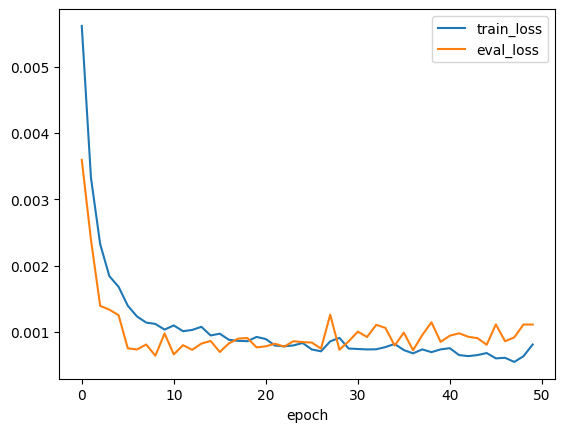

In [19]:
pd.DataFrame(history_cnn).plot(x='epoch', y=['train_loss', 'eval_loss'])

In [20]:
with torch.no_grad():
    y_pred_cnn_train = model_cnn(X_train.unsqueeze(1))
    y_pred_cnn_val = model_cnn(X_val.unsqueeze(1))
    y_pred_cnn_test = model_cnn(X_test.unsqueeze(1))

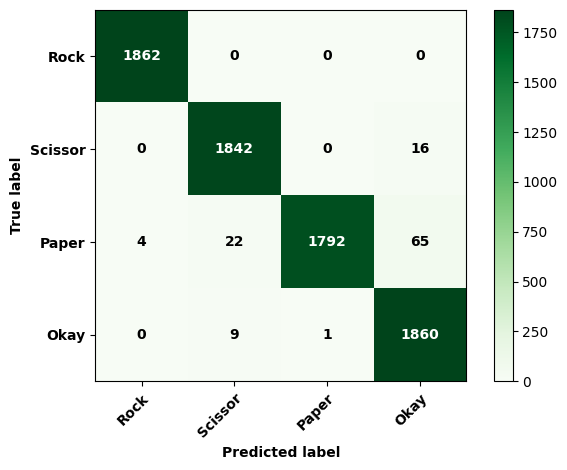

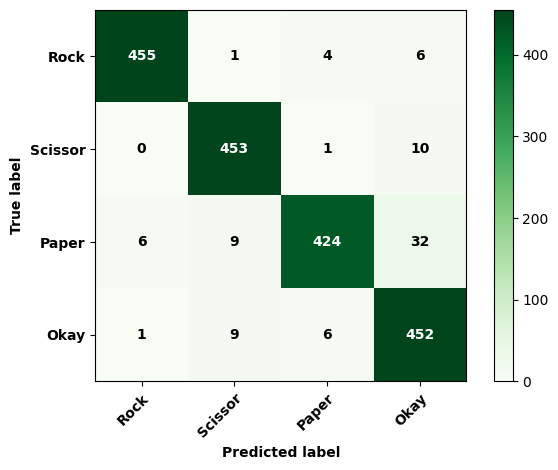

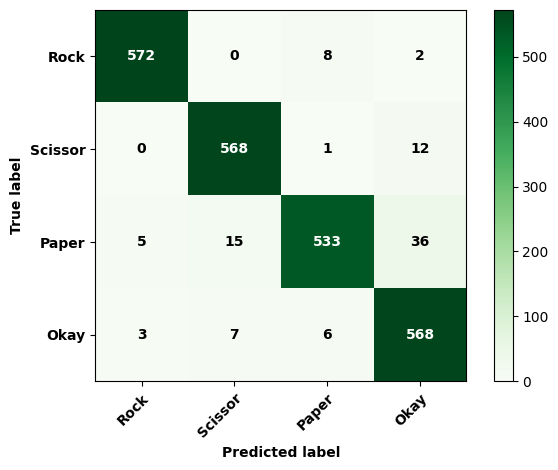

Train
Accuracy: 98.4344%
Precision: 98.4754%
Recall: 98.4428%
F1 score: 98.4356%

Validation
Accuracy: 95.4521%
Precision: 95.5827%
Recall: 95.4678%
F1 score: 95.4605%

Test
Accuracy: 95.9332%
Precision: 96.0160%
Recall: 95.9492%
F1 score: 95.9317%


In [46]:
plot_confusion_matrix(y_train, y_pred_cnn_train.argmax(dim=1))
plot_confusion_matrix(y_val, y_pred_cnn_val.argmax(dim=1))
plot_confusion_matrix(y_test, y_pred_cnn_test.argmax(dim=1))

print('Train')
score_train(y_train, y_pred_cnn_train.detach().numpy().argmax(axis=1))
print()
print('Validation')
score_val(y_val, y_pred_cnn_val.detach().numpy().argmax(axis=1))
print()
print('Test')
score_test(y_test, y_pred_cnn_test.detach().numpy().argmax(axis=1))

In [22]:
model = pd.DataFrame(columns=['Model','Accuracy', 'Precision', 'Recall', 'F1 Score', 'Training Time', 'Testing Time'])
model.loc[0] = ['CNN_Train',accuracy_cnn_train,precision_cnn_train,recall_cnn_train,f1_cnn_train,training_time_cnn,'-']
model.loc[1] = ['CNN_Val',accuracy_cnn_val,precision_cnn_val,recall_cnn_val,f1_cnn_val,'-','-']
model.loc[2] = ['CNN_Test',accuracy_cnn_test,precision_cnn_test,recall_cnn_test,f1_cnn_test,'-',testing_time_cnn]
model

,Model,Accuracy,Precision,Recall,F1 Score,Training Time,Testing Time
0,CNN_Train,98.434364,98.475415,98.442846,98.435611,113.092778,-
1,CNN_Val,95.452113,95.582672,95.467806,95.460470,-,-
2,CNN_Test,95.933219,96.016009,95.949225,95.931674,-,0.208667
